 Importing Libraries and Dependencies

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# Importing necessary packages
import tempfile
from tensorflow.keras.models import model_from_json
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=15, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/model_plot.png", help="Path to save model's plot")
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument("--model_name", type=str, default="VGG16_CW.h5", help="Name of the model")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

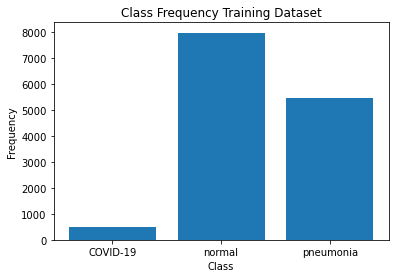

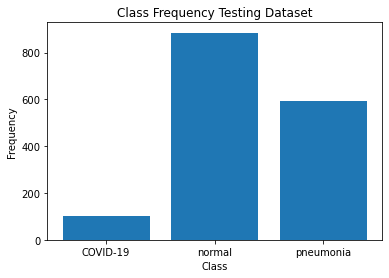

In [3]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Instantiating data generators to load datasets

In [4]:
# Initialising data augmentation object to improve the dataset
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.33
)

test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=os.path.join(args.data_dir, args.train_data_dir),
    x_col="file_name",
    y_col="class",
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=BS,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=14
)

validation_generator = train_data_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=os.path.join(args.data_dir, args.train_data_dir),
    x_col="file_name",
    y_col="class",    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=BS,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=14
)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=df_test,
    directory=os.path.join(args.data_dir, args.test_data_dir),
    x_col="file_name",
    y_col="class",
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    validate_filenames=False
)

Found 9330 validated image filenames belonging to 3 classes.
Found 4595 validated image filenames belonging to 3 classes.
Found 1579 non-validated image filenames belonging to 3 classes.


Creating the model

In [5]:
# Method to add regularisation
def add_regularization(model, regularizer=regularizers.l2(0.0001)):

    if not isinstance(regularizer, regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # Load the model from the config
    model = model_from_json(model_json)

    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

# Loading VGG16 model trained on imagenet without head
baseModel = VGG16(
    weights="imagenet", include_top=False,
    input_tensor=Input(shape=(args.input_size, args.input_size,
                              args.n_channels))
)

# Constructing the head for classification (to be trained)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model = add_regularization(model)

# Fixing the weights of base model
for layer in baseModel.layers:
	layer.trainable = False

# Saving a plot of the model
plot_model(model, to_file=args.model_plot, show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Training the model

In [6]:
# Compiling the model
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy','AUC'])

# CREATE CALLBACKS
checkpoint = ModelCheckpoint(args.model_dir+args.model_name, 
                        monitor='val_auc', verbose=1, 
                        save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=2)
callbacks_list = [checkpoint, es]

# Calculating class weights since COVID-19 data is very less
cw = class_weight.compute_class_weight('balanced',['normal','pneumonia','COVID-19'],train_labels)
class_weights = {0:cw[0],1:cw[1],2:cw[2]}
print(class_weights)
# Training model
print("[INFO] Training model")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=class_weights)

{0: 0.5826847434931793, 1: 0.8496552565745317, 2: 9.358198924731182}
[INFO] Training model


/homes/as405/anaconda3/envs/covid/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=['normal', 'pneumonia', 'COVID-19'], y=0        pneumonia
1        pneumonia
2        pneumonia
3        pneumonia
4        pneumonia
           ...    
13920    pneumonia
13921    pneumonia
13922    pneumonia
13923    pneumonia
13924    pneumonia
Name: class, Length: 13925, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1167/1167 [==============================] - ETA: 0s - loss: 1.2761 - accuracy: 0.6056 - auc: 0.8614
Epoch 00001: val_auc improved from -inf to 0.47519, saving model to saved_models/VGG16_CW.h5
1167/1167 [==============================] - 835s 715ms/step - loss: 1.2761 - accuracy: 0.6056 - auc: 0.8614 - val_loss: 3.1149 - val_accuracy: 0.0973 - val_auc: 0.4752
Epoch 2/15
1167/1167 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.6544 - auc: 0.8936
Epoch 00002: val_auc improved from 0.47519 to 0.67381, saving model to saved_models/VGG16_CW.h5
1167/1167 [==============================] - 715s 612ms/step - loss: 0.9984 - accuracy: 0.6544 - auc: 0.8936 - val_loss: 3.2023 - val_accuracy: 0.5132 - val_auc: 0.6738
Epoch 3/15
1167/1167 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.7066 - auc: 0.9114
Epoch 00003: val_auc did not improve from 0.67381
1167/1

Evaluating the model and generating predictions

In [7]:
# Evaluating model on training data
print("[INFO] Evaluating model on training data")
model.evaluate_generator(generator=validation_generator,
                         steps=validation_generator.samples // BS)

# Predicting on testing data
print("[INFO] Predicting on testing data")
test_file_names = test_generator.filenames
nb_samples = len(test_file_names)
test_generator.reset()
pred = model.predict_generator(test_generator, steps=nb_samples, verbose=1)
pred = np.argmax(pred, axis=1)

# Getting class label map
label_map = (test_generator.class_indices)
for c in classes:
    label_map.update({label_map.get(c): c})
    label_map.pop(label_map.get(label_map.get(c)))
temp = []
for i in range(len(label_map)):
    temp.append(label_map.get(i))
label_map = temp
del(temp)

# Printing classification report
print(classification_report(test_generator.classes, pred, target_names=label_map))

[INFO] Evaluating model on training data
Instructions for updating:
Please use Model.evaluate, which supports generators.
[INFO] Predicting on testing data
Instructions for updating:
Please use Model.predict, which supports generators.
1579/1579 [==============================] - 57s 36ms/step
              precision    recall  f1-score   support

    COVID-19       0.00      0.00      0.00       100
      normal       0.98      0.05      0.10       885
   pneumonia       0.39      1.00      0.56       594

    accuracy                           0.41      1579
   macro avg       0.46      0.35      0.22      1579
weighted avg       0.69      0.41      0.27      1579



/homes/as405/anaconda3/envs/covid/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
t=class_weight.compute_class_weight('balanced',['normal','pneumonia','COVID-19'],train_labels)
cw = {0:t[0],1:t[1],2:t[2]}
print(cw)

{0: 0.5826847434931793, 1: 0.8496552565745317, 2: 9.358198924731182}


Printing confusion matrix

In [9]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(test_generator.classes, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

[[  0   0 100]
 [  0  47 838]
 [  0   1 593]]
Overall Accuracy: 0.4053
COVID Sensitivity: 0.0000
COVID Specificity: 1.0000


Plotting the training performance

ValueError: x and y must have same first dimension, but have shapes (15,) and (4,)

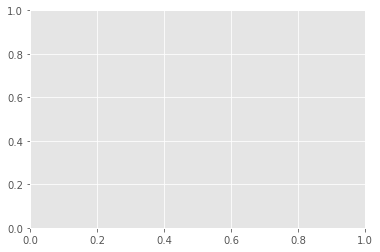

In [10]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
args.plot = "plot_vgg16_sgd.png"
plt.savefig(args.plot)